# ¿Existirán grupos de personas que compartan la misma tasa de reincidencia? Si existen, ¿Qué atributos componen a dichos grupos?

Como se vio en la pregunta 4, las tablas que poseen una gran incidencia en el decile score es principalmente people, por lo que mediante un script de r se decide juntar esta con datos relevantes de charge

Porque incluir charge a pesar de su baja correlacion con decile score?

- Consideramos que contiene información util que puede revelar alguna agrupacion natural, ademas de informacion con respecto a la reincidencia
- Jailhistory se descarta por tener datos similares a los de people

In [60]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors


In [61]:
# Load data
main_people = pd.read_csv('../data/cleaned/people_joined_charge_decile.csv', index_col=0).drop('c_days_from_compas', axis=1)
main_people.head()

,id,sex,race,dob,juv_fel_count,juv_misd_count,juv_other_count,compas_screening_date,priors_count,days_b_screening_arrest,...,min_degree,avg_degree,med_degree,charges_recid,charges_no_recid,charges_total,charge_latest,decile_recid,decile_violence,decile_fail_to_appear
1,1,Male,Other,0.27451,0,0,0,0.93632,0,-0.00003,...,0.00,0.18125,0.000,2,6,8,0.93900,1,1,1
2,3,Male,African-American,0.62141,0,0,0,0.93088,0,-0.00003,...,0.85,0.86250,0.850,3,1,4,0.93523,3,1,6
3,4,Male,African-American,0.71427,0,0,1,0.93299,4,-0.00003,...,0.00,0.45833,0.600,17,19,36,0.96159,4,3,7
4,5,Male,African-American,0.73115,0,1,0,0.93050,1,0.00000,...,0.00,0.37143,0.550,2,5,7,0.94266,8,6,3
5,6,Male,Other,0.53161,0,0,0,0.93247,2,0.00000,...,0.00,0.57500,0.725,0,4,4,0.92342,1,1,1


In [62]:
# Ahora pasamos los elementos categoricos a numericos
main_people.replace(['Male', 'Female'], [1, 0], inplace=True)
people_race = pd.get_dummies(main_people['race'], prefix='race', prefix_sep="_")
main_people = pd.concat([main_people, people_race], axis=1).drop('race', axis=1)
main_people.head()

,id,sex,dob,juv_fel_count,juv_misd_count,juv_other_count,compas_screening_date,priors_count,days_b_screening_arrest,c_jail_in,...,charge_latest,decile_recid,decile_violence,decile_fail_to_appear,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other
1,1,1,0.27451,0,0,0,0.93632,0,-0.00003,0.93629,...,0.93900,1,1,1,0,0,0,0,0,1
2,3,1,0.62141,0,0,0,0.93088,0,-0.00003,0.93085,...,0.93523,3,1,6,1,0,0,0,0,0
3,4,1,0.71427,0,0,1,0.93299,4,-0.00003,0.93296,...,0.96159,4,3,7,1,0,0,0,0,0
4,5,1,0.73115,0,1,0,0.93050,1,0.00000,0.93050,...,0.94266,8,6,3,1,0,0,0,0,0
5,6,1,0.53161,0,0,0,0.93247,2,0.00000,0.93247,...,0.92342,1,1,1,0,0,0,0,0,1


In [63]:
# Como se ve, las columnas que corresponden a reincidencia son is_recid, num_r_cases, charges_recid, charges_not_recid, decile_recid
# Entonces las quitamos para hacer el clustering
blind_recid_people = main_people.drop(['is_recid', 'num_r_cases', 'charges_recid', 'charges_no_recid', 'decile_recid'], axis=1)
blind_recid_people.head()

,id,sex,dob,juv_fel_count,juv_misd_count,juv_other_count,compas_screening_date,priors_count,days_b_screening_arrest,c_jail_in,...,charges_total,charge_latest,decile_violence,decile_fail_to_appear,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other
1,1,1,0.27451,0,0,0,0.93632,0,-0.00003,0.93629,...,8,0.93900,1,1,0,0,0,0,0,1
2,3,1,0.62141,0,0,0,0.93088,0,-0.00003,0.93085,...,4,0.93523,1,6,1,0,0,0,0,0
3,4,1,0.71427,0,0,1,0.93299,4,-0.00003,0.93296,...,36,0.96159,3,7,1,0,0,0,0,0
4,5,1,0.73115,0,1,0,0.93050,1,0.00000,0.93050,...,7,0.94266,6,3,1,0,0,0,0,0
5,6,1,0.53161,0,0,0,0.93247,2,0.00000,0.93247,...,4,0.92342,1,1,0,0,0,0,0,1


<AxesSubplot:>

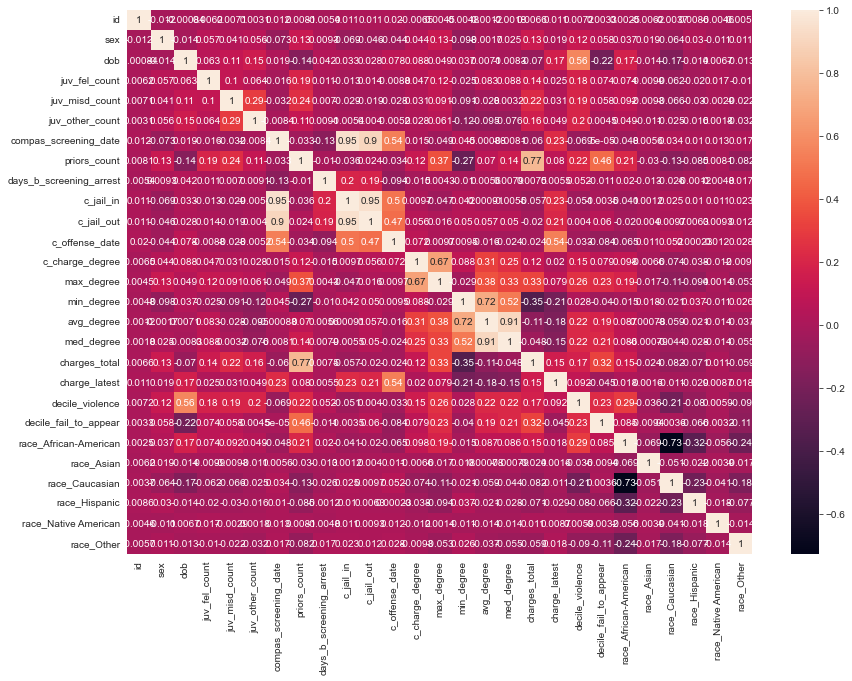

In [64]:
# Ahora revisamos si existen elementos muy correlacionados
plt.figure(figsize=(14, 10))
sns.heatmap(blind_recid_people.corr(), annot=True)

<AxesSubplot:>

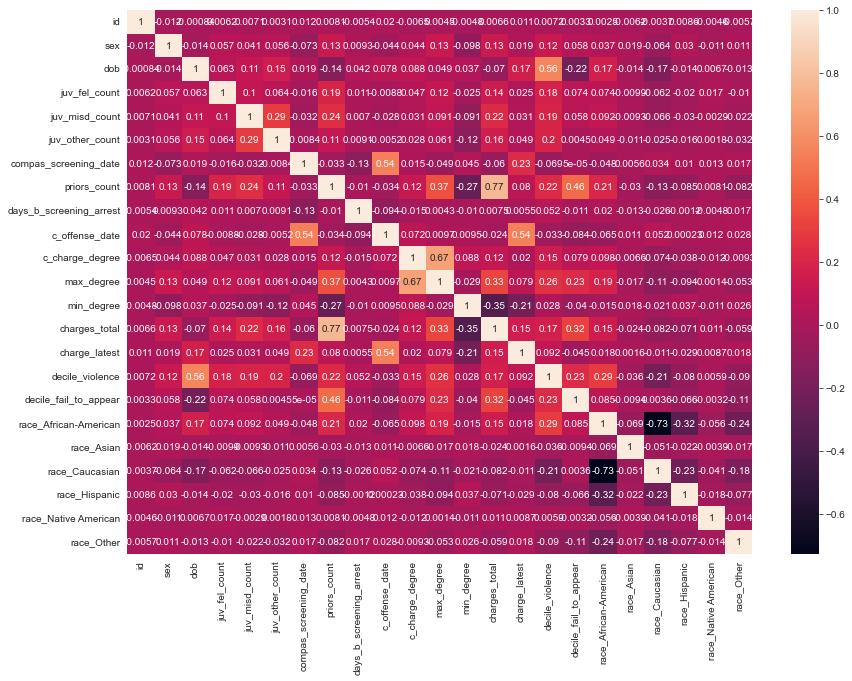

In [65]:
# Como se ve, la correlacion entre c_jail_in y c_jail_out es muy alta, por lo que podemos dejar compas_screening_date como representante de ambos.
# Lo mismo pasa con min, med y avg degree, con lo cual podemos quedarnos con min
# priors_count y degrees_total tambien, pero a pesar de tener una relación alta, son cosas distintas.
blind_recid_people.drop(['c_jail_in', 'c_jail_out', 'med_degree', 'avg_degree'], axis=1, inplace=True)
plt.figure(figsize=(14, 10))
sns.heatmap(blind_recid_people.corr(), annot=True)

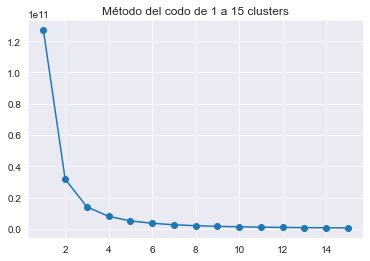

In [66]:
# Ahora podemos hacer clustering, empezando con KMeans
# Usaremos la técnica del codo
km_sse = []
km_clusters = [i for i in range(1, 16)]
for k in km_clusters:
    kmeans = KMeans(n_clusters=k).fit(blind_recid_people)
    km_sse.append(kmeans.inertia_)

plt.plot(km_clusters, km_sse, marker='o')
plt.title('Método del codo de 1 a 15 clusters')
plt.grid(True)
plt.show()

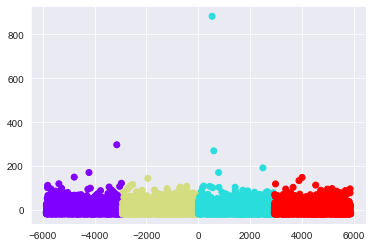

In [67]:
# Usaremos 4 clusters
kmeans = KMeans(n_clusters=4, random_state=0).fit(blind_recid_people)
km_cl = kmeans.labels_
# Reducimos la dimensionalidad usando PCA para ver los resultados visuales
X = PCA(n_components=2, random_state=0).fit_transform(main_people)
plt.scatter(X[:, 0], X[:, 1], c=km_cl, cmap='rainbow')

In [109]:
# Revisamos el porcentaje de reincidencia por cluster
main_people['km_cl'] = km_cl
main_people.groupby('km_cl').is_recid.mean()

km_cl
0    0.321416
1    0.342471
2    0.336968
3    0.336476
Name: is_recid, dtype: float64

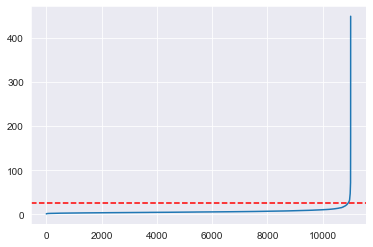

In [101]:
# Demasiado iguales con respecto a la reincidencia, por lo que cambiamos a DBSCAN
# Usaremos la tecnica de la rodilla para 3 distintos k=[4,5,6]
nbrs = NearestNeighbors(n_neighbors=10).fit(blind_recid_people)
distances, indices = nbrs.kneighbors(blind_recid_people)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.axhline(y=25, color='r', linestyle='--') #Ajuste el valor para y
plt.plot(distances)
plt.show()


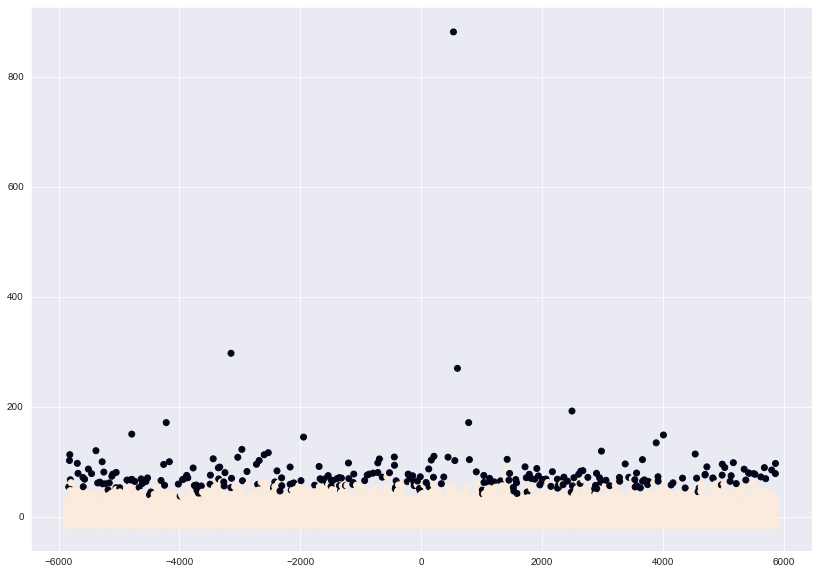

In [105]:
# Nos quedamos con 25 y 4
dbscan = DBSCAN(eps=25, min_samples=10).fit(blind_recid_people)
db_cl = dbscan.labels_
plt.figure(figsize=(14, 10))
plt.scatter(X[:, 0], X[:, 1], c=db_cl)

In [115]:
# Revisamos la reincidencia por cluster, filtramos los outlayers
main_people['db_cl'] = db_cl
main_people.groupby('db_cl').is_recid.mean()

db_cl
-1    0.719101
 0    0.324742
Name: is_recid, dtype: float64

In [116]:
# DBScan no nos da una solucion buena para la reincidencia, pues solo consigue identificar outlayers, por lo mismo, puede que sirva como metodo de subsampling para la clasificacion
main_people.db_cl.value_counts()

 0    10747
-1      267
Name: db_cl, dtype: int64